# Classification using Transformer

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
stop_words = stopwords.words('korean')
from konlpy.tag import Okt
from gensim.models import Word2Vec
import googletrans, random, re
from typing import List

import tensorflow as tf

## Load Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape)
train.head()

(25000, 3)


,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


## EDA

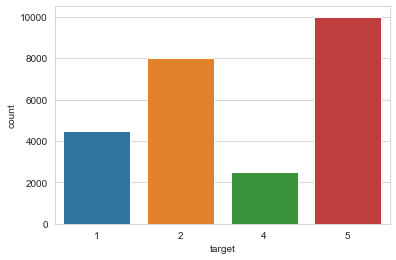

In [3]:
sns.set_style('whitegrid')
sns.countplot(data=train, x='target')
plt.show()

### Data Augmentation
- 라벨 간 불균형을 조정하기 위해 번역을 활용한 데이터 증강기법 적용

1. 한글 > 영어(,프랑스어,일본어,중국어) > 한글 역번역
- 결과가 만족스럽지 않음

In [4]:
import googletrans

translator = googletrans.Translator()

for i in [10,20,30]:
    original = train[train['target']==1]['reviews'].iloc[i]
    translated = translator.translate(original, dest='en').text
    result = translator.translate(translated, dest='ko').text

    print(original)
    print(result)
    print('-'*50)

생각보다 맛이 별로라
내가 생각했던 것보다 맛이 좋습니다
--------------------------------------------------
배송도 빠르고 눈썹은 괜찮은데 글로가 정말 별로네요ㅜ
배달은 빠르고 눈썹은 괜찮지 만 글은 정말 좋습니다.
--------------------------------------------------
실제 보고 인터넷으로 구매한건데 정품이 아닌건지 유난히 가방이 가로가 길어요;; 여자가 들기엔 안예쁜것 같아요. 남자 운동 가방으로 그나마 쓸것같네요....
사실, 나는 인터넷에서 그것을 샀지 만 가방은 비정상적으로 길다. 나는 그것이 여자라고 생각하지 않는다. 나는 그것이 남성 운동 가방이 될 것이라고 생각한다 ....
--------------------------------------------------


2. NLPAUG 동의어 변환
- WordNet에서 한글 소스가 존재하지 않음

In [5]:
import nlpaug.augmenter.word as naw

aug = naw.SynonymAug()
text = 'red apple'
aug.augment(text)

['red malus pumila']

3. 역번역 중간에 NLPAUG 적용
- 더욱 다른 의미로 변환되어 데이터의 품질 저하 발생

In [6]:
for i in [10,20,30]:
    original = train[train['target']==1]['reviews'].iloc[i]
    translated = translator.translate(original, dest='en').text
    translated = aug.augment(translated)[0]
    result = translator.translate(translated, dest='ko').text

    print(original)
    print(result)
    print('-'*50)

생각보다 맛이 별로라
정보 기술은 생각보다 맛이 좋습니다
--------------------------------------------------
배송도 빠르고 눈썹은 괜찮은데 글로가 정말 별로네요ㅜ
배달은 빠르게 살고 눈썹은 괜찮지 만 글은 진정한 전문가입니다.
--------------------------------------------------
실제 보고 인터넷으로 구매한건데 정품이 아닌건지 유난히 가방이 가로가 길어요;; 여자가 들기엔 안예쁜것 같아요. 남자 운동 가방으로 그나마 쓸것같네요....
사실, 나는 사이버 공간에서 그것을 뇌물을 뿌리고 가방만이 비정상적으로 멀리 떨어져 있습니다.나는 그것이 여자라고 생각하지 않습니다.정보 기술의 크로크는 남자와 같은 운동 그립이라고 생각합니다....
--------------------------------------------------


4. 토큰 단위로 역번역
- 상대적으로 나은 결과가 확인되지만, 변환 속도가 매우 느린 단점

In [4]:
def ko_tokenize(sentence):
    okt = Okt()
    sentence = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','',sentence)
    tokenized = okt.morphs(sentence, stem=True)
    return [word for word in tokenized if word not in stop_words]

In [9]:
for i in [10,20,30]:
    original = ko_tokenize(train[train['target']==1]['reviews'].iloc[i])
    translated = [translator.translate(token, dest='en').text for token in original]
    result = [translator.translate(token, dest='ko').text for token in translated]
    result = ko_tokenize(' '.join(result))

    print(original)
    print(result)
    print('-'*50)

['생각', '보다', '맛', '별로', '라']
['생각', '하다', '보다', '맛', '그만큼']
--------------------------------------------------
['배송', '도', '빠르다', '눈썹', '은', '괜찮다', '글로', '정말', '별로', '요', 'ㅜ']
['배송', '하다', '빠르다', '눈썹', '은', '괜찮다', '진짜', '에야', '디', '흐', '느낌']
--------------------------------------------------
['실제', '보고', '인터넷', '한', '건데', '정품', '아니다', '건지다', '유난히', '가방', '가로', '기다', '여자', '들다', '기', '엔', '안', '예쁘다', '남자', '운동', '가방', '그나마', '쓸다']
['진짜', '보고서', '인터넷', '진실하다', '아니다', '떠나다', '비정상', '적', '가방', '너비', '기', '다', '여성', '잡고', '에너지', '아니다', '예쁘다', '남성', '운동', '가방', '기부', '스', '위프']
--------------------------------------------------


5. Word2Vec를 활용한 유사어 변환
- 원본 문장과는 전혀 다른 의미가 되어버리지만, 전반적인 감정 수준은 유지되는 것을 확인

In [6]:
from gensim.models import Word2Vec

num_features = 300
train_data = [ko_tokenize(data) for data in train[train['target']==1]['reviews']]
model = Word2Vec(sentences=train_data, vector_size=num_features, window=5, min_count=1, workers=4, sg=0)

In [12]:
for i in [10,20,30]:
    original = ko_tokenize(train[train['target']==1]['reviews'].iloc[i])
    result = list()
    for token in original:
        synonym = model.wv.most_similar(token)[0]
        result.append(synonym[0] if synonym[1] > 0.95 else token)
    result = list(set(result))

    print(original)
    print(result)
    print('-'*50)

['생각', '보다', '맛', '별로', '라']
['아니다', '서', '완전', '고']
--------------------------------------------------
['배송', '도', '빠르다', '눈썹', '은', '괜찮다', '글로', '정말', '별로', '요', 'ㅜ']
['오다', '눈썹', '아니다', '는', '완전', '느리다', '상품', '이다', '글로']
--------------------------------------------------
['실제', '보고', '인터넷', '한', '건데', '정품', '아니다', '건지다', '유난히', '가방', '가로', '기다', '여자', '들다', '기', '엔', '안', '예쁘다', '남자', '운동', '가방', '그나마', '쓸다']
['유난히', '말다', '걸', '오다', '시', '고', '되다', '비싸다', '아니다', '막', '적', '는', '연결', '않다', '나오다']
--------------------------------------------------


Word2Vec와 역번역을 활용해 Augmentation을 수행하는 함수 정의   
전처리 과정에서 해당 함수를 활용해 평점 별 데이터 수를 10000개로 조정

In [3]:
def ko_tokenize(sequence: str):
    okt = Okt()
    tokenized = okt.morphs(sequence, stem=True)
    return [word for word in tokenized if word not in stop_words]

def get_synonym(word: str, model: Word2Vec, match_rate: float):
    pred = model.wv.most_similar(word)[0]
    return pred[0] if pred[1] > match_rate else word

def get_translated(word: str, translator: googletrans.Translator):
    try:
        en_translated = translator.translate(word, dest='en').text
        kr_translated = translator.translate(en_translated, dest='ko').text
        return kr_translated
    except:
        return word

def unique_matrix(matrix: List[List[str]]):
    matrix = list(set([' '.join(array) for array in matrix if len(array) > 0]))
    return [str(array).split() for array in matrix]

def word2vec_aug(sequences: List[str], num_aug: int, num_features=300) -> List[List[str]]:
    num_aug = num_aug - len(sequences)
    tokenized = [ko_tokenize(sequence) for sequence in sequences]
    model = Word2Vec(sentences=tokenized, vector_size=num_features, window=5, min_count=1, workers=4, sg=0)
    translator = googletrans.Translator()

    augmented, match_rate = list(), 0.95
    while len(augmented) < num_aug:
        synonyms = [list({get_synonym(token, model, match_rate) for token in sequence}) for sequence in tokenized]
        translated = [ko_tokenize(' '.join([get_translated(token, translator) for token in sequence])) for sequence in tokenized]
        augmented = unique_matrix(augmented + unique_matrix(synonyms) + unique_matrix(translated))
        match_rate = max(match_rate-0.05, 0.70)
        tokenized = unique_matrix(synonyms)

    return random.sample(augmented, num_aug)

In [ ]:
augmented = word2vec_aug(train[train['target']==1]['reviews'].tolist(), 10000)
augmented

## Preprocess Data

In [4]:
train['reviews'] = train['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
test['reviews'] = test['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')

train['reviews'] = train['reviews'].str.replace('^ +','')
test['reviews'] = test['reviews'].str.replace('^ +','')

In [5]:
okt = Okt()
train_data = [ko_tokenize(review) for review in train['reviews'].tolist()]
train_label = train['target'].tolist()
test_data = [ko_tokenize(review) for review in test['reviews'].tolist()]

num_aug = train['target'].value_counts().max()
for rate in train['target'].unique():
    reviews = train[train['target']==rate]['reviews'].tolist()
    if len(reviews) == num_aug:
        continue

    augmented = word2vec_aug(reviews, num_aug)
    train_data += augmented
    train_label += [rate for _ in range(len(augmented))]

In [ ]:
pd.DataFrame({'reviews':train_data,'target':train_label}).to_csv('data/tokenized1.csv',index=False)

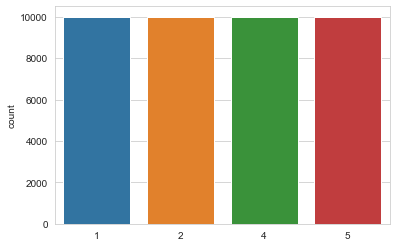

In [7]:
sns.set_style('whitegrid')
sns.countplot(data={'target':train_label}, x='target')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = \
    train_test_split(train_data, train_label, test_size=0.3,
                        stratify=train_label, shuffle=True, random_state=0)

print(len(train_X), len(train_y), len(val_X), len(val_y))

17500 17500 7500 7500


## Transformer

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [2]:
vocab_size = 20000  # 빈도수 상위 2만개의 단어만 사용
max_len = 200  # 문장의 최대 길이

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))

17464789/17464789 [==============================] - 2s 0us/step
훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000


In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [ ]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

In [ ]:
print(train_X['input_ids'][0])

[2, 12978, 3409, 5926, 11988, 16, 16305, 5868, 8297, 13365, 5842, 6136, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(train_X['token_type_ids'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(train_X['attention_mask'][0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, initializers, losses, optimizers, metrics, callbacks 

SEQ_LEN = 512 # 최대 token 개수 이상의 값으로 임의로 설정

koelectra = ElectraModel.from_pretrained('monologg/koelectra-base-discriminator')

input_token_ids   = layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_token_ids')   # tokens_tensor
input_masks       = layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')       # masks_tensor
input_segments    = layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segments')    # segments_tensor  

koelectra_outputs = koelectra([input_token_ids, input_masks, input_segments]) 
# koelectra_outputs -> 0: 'last_hidden_state' & 1: 'pooler_output' (== applied GlobalAveragePooling1D on 'last_hidden_state')

koelectra_outputs = koelectra_outputs[1]
koelectra_outputs = layers.Dropout(0.2)(koelectra_outputs)
final_output = layers.Dense(units=4, activation='softmax', kernel_initializer=initializers.TruncatedNormal(stddev=0.02), name="classifier")(koelectra_outputs)

model = tf.keras.Model(inputs=[input_token_ids, input_masks, input_segments], 
                       outputs=final_output)

In [ ]:
import os

checkpoint_path = 'saved_models/'

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)


# For custom models, we have to use "save_weights_only = True" (or we should implement a "get_config" method @ https://j.mp/3ltUibd) 
callback_checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path + 'koelectra_weight.h5', # 이번 실습에서 변경되었습니다
                                                monitor='val_sparse_categorical_accuracy',
                                                save_best_only=True, 
                                                save_weights_only = True, 
                                                verbose=1) 
                                                
# Early-stopping for preventing the overfitting
callback_earlystop = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                             min_delta=0.0001, # the threshold that triggers the termination (acc should at least improve 0.0001)
                                             patience=5) #  Number of epochs with no improvement after which training will be stopped

In [ ]:
# 25분 가량 소요됩니다 (epochs를 4~5 정도로 주더라도 비슷한 수준으로 학습이 가능합니다)

history = model.fit(train_X, train_y, validation_split=0.2,
                    epochs=10, batch_size=100,
                    verbose=1,
                    callbacks=[callback_checkpoint, callback_earlystop])